# Case Técnico Fácil Espaider: Classificação Multilabel de gêneros de filmes baseado em sinopse

## Planejamento da Solução

### Entrada

* Base de metadados de filmes com as característica de cada um dos filmes e seus respectivos gêneros atribuídos.
* Sinopse dos filmes com identificador usado para se referenciar a base de metadados dos filmes.
                                                

### Saída

* Qual formato de entrega da solução?

    * 1 Jupyter Notebooks, onde o projeto foi desenvolvido por meio de ciclos, com objetivo de gerenciar e planejar os próximos passos.
    * 2 O modelo está em produção através de uma API criada e hospedada no WebService do Render. As previsões geradas por esse modelo podem ser acessadas por meio de um BOT no Telegram (https://t.me/genrespred_bot). Para utilizar o BOT, basta inserir a sinopse de um filme como entrada e, em seguida, será realizada uma consulta à API do modelo para retornar os gêneros correspondentes à sinopse digitada.

<font size ="2" > PS: *É importante observar que o Telegram tem um limite máximo de 4096 caracteres para cada mensagem enviada. Se a sinopse de um filme ultrapassar esse limite, ela será dividida em duas ou mais mensagens. Nesse caso, o modelo fará uma nova previsão para cada uma dessas partes da mensagem. Portanto, caso queira testar uma sinopse com tamanho maior que 4096 caracteres, estarei disponibilizando uma função ao fim do código para esse teste.* </font>


    


Metodologia
* CRISP-DS, metodologia ágil para desenvolvimento de projetos de ciência de dados (método cíclico).
* Abordagem Classificação MultiLabel utilizando NLP


Ferraments Utilizadas
* Python 3.10.6, Jupyter-Lab, Poetry, Git, Github, Render, Flask API.

## Implementações realizadas na Sprint

### Ciclo 1

* Entendimento do problema.
* Importações de Bibliotecas e Funções Auxiliares Iniciais.
* Leitura e Entendimento dos Dados.
* Descrição dos dados.
* Filtragem das variáveis que serão utilizadas no modelo.
* Análise Exploratória dos dados para variável resposta (gêneros dos filmes)
* Análise Exploratória da distribuição dos gêneros de filmes.
* Featuring Engineering (Criação de features utilizando TFIDF - bag of words )
* Teste Inicial de Modelos e Métricas


# 0.0 Imports and Helper Functions

In [7]:
import pandas as pd
import csv
from tqdm import tqdm
import json
import nltk 

from matplotlib import pyplot as plt
from IPython.core.display import HTML
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import MultiLabelBinarizer


In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier

## 0.1 Auxiliar Functions

In [9]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()


# 1.0 Data Description

## 1.1 Leitura Dados dos Filmes

In [10]:
df1 = pd.read_csv("../data/movie.metadata.tsv", sep = '\t', header = None)
df1.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Dataset sem identificação das colunas, vamos então dar nome a aquelas que nos interessa 

### 1.1.1 Rename Columns

In [11]:
df1.columns = ['id_filme','col_2', 'nome_filme', 'cod_3', 'cod_4', 'cod_5', 'cod_6','cod_7','genero_filme']
df1.head()

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 1.2 Leitura Dados de Entrada ( Sinopses dos Filmes em formato txt)

In [12]:
sinopse = []

with open("../data/plot_summaries.txt", 'r') as file:
    texto = csv.reader(file,dialect='excel-tab')
    
    for row in tqdm(texto):
        sinopse.append(row)

42303it [00:00, 79586.03it/s]


In [13]:
sinopse[:2]

[['23890098',
  "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."],
 ['31186339',
  'The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at speci

Aqui então nós temos o id e sinopse do filme, no qual utilizaremos o id como referência ao dataset de filmes e seu gênero correspondente
- Próximo Passo então:
    * Extrair o id e a sinopse de cada elemento da lista e adicionar para um DataFrame

In [14]:
id_filme = []
sinopse_filme = []

In [15]:
for i in tqdm(sinopse):
    id_filme.append(i[0])
    sinopse_filme.append(i[1])
    
# Montar o DataFrame 

df_sinopse = pd.DataFrame({'id_filme':id_filme, 'sinopse_filme': sinopse_filme})
df_sinopse.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 2518690.09it/s]


,id_filme,sinopse_filme
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [16]:
df1.duplicated().sum()

0

In [17]:
df_sinopse.duplicated().sum()

0

## 1.3 Data Types

In [18]:
df1.head()

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [19]:
df1.dtypes

id_filme          int64
col_2            object
nome_filme       object
cod_3            object
cod_4           float64
cod_5           float64
cod_6            object
cod_7            object
genero_filme     object
dtype: object

In [20]:
df_sinopse.head()

,id_filme,sinopse_filme
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [21]:
df_sinopse.dtypes

id_filme         object
sinopse_filme    object
dtype: object

Vamos então agora unir os 2 dataframes por meio de seu id, para que assim possamos analisar os dados por completo em um só DataFrame

In [22]:
df1['id_filme'] = df1['id_filme'].astype(str)

## 1.4 Data Dimension

In [23]:
df1.shape

(81741, 9)

In [24]:
df1.head()

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Podemos observar então que para o dataset de filmes, nós temos então 81741 linhas contendo as informações dos filmes.

In [25]:
df_sinopse.shape

(42303, 2)

O dataset de sinopses fornecidas é de 42303 filmes, ou seja nem todos filmes cadastrados no primeiro dataset possuem sua sinopse disponível.

## 1.5 Join Datasets

In [26]:
df_final = pd.merge(df1,df_sinopse,on='id_filme',how='left')

In [27]:
df_final.sample(10)

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme,sinopse_filme
67734,32734042,/m/0fq56y6,The Devil Pays Off,1941-11-10,NaN,70.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
23485,25339461,/m/09g75z3,Christian Brothers,2010-07-07,NaN,175.0000,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",The film is about Palamattathu Varghese Mappil...
53438,11440374,/m/02rcq2c,Dance 'Til Dawn,1988-10-23,NaN,100.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hqxf"": ""F...",It's the day of the senior prom at Herbert Hoo...
62902,27027207,/m/09sx1w_,Countdown to Zero,2010-01-25,NaN,91.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n07"": ""Culture & Society"", ""/m/03g3w""...",NaN
21005,32942612,/m/0h3b2yt,The Moth Diaries,2011-09-06,NaN,85.0000,"{""/m/0t_2"": ""American English""}","{""/m/03rt9"": ""Ireland"", ""/m/0d060g"": ""Canada""}","{""/m/03npn"": ""Horror""}",NaN
29495,3229348,/m/08_wst,Deliria,1987-02-08,NaN,90.0000,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/03rjj"": ""Italy""}","{""/m/01jfsb"": ""Thriller"", ""/m/06vxwl5"": ""Natur...",The film takes place in a theater late at nigh...
65212,23687745,/m/06zpr0d,Gli Uomini non guardano il cielo,1951,NaN,90.0000,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/017fp"": ""Biography"", ""/m/07s9rl0"": ""Drama""}",NaN
16942,8132688,/m/026ssgk,Any Day Now,1976-02-19,NaN,93.0000,"{""/m/02bv9"": ""Dutch Language""}","{""/m/059j2"": ""Netherlands""}","{""/m/04rlf"": ""Music"", ""/m/06n90"": ""Science Fic...",NaN
78963,22753349,/m/05zx9vc,Backbone,1975,NaN,91.0000,"{""/m/06x8y"": ""Serbo-Croatian""}","{""/m/087vz"": ""Yugoslavia""}","{""/m/07s9rl0"": ""Drama""}",NaN
28731,12594236,/m/02wx31m,Night of the Living Duck,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hqxf"": ""Famil...","Daffy Duck, here a horror fanatic, is reading ..."


## 1.6 Check NA / Duplicated Rows

In [28]:
df_final.isna().sum()

id_filme             0
col_2                0
nome_filme           0
cod_3             6902
cod_4            73340
cod_5            20450
cod_6                0
cod_7                0
genero_filme         0
sinopse_filme    39537
dtype: int64

# 2.0 Data Filtering

In [29]:
df2 = df_final.copy()

## 2.1 Select Columns

In [30]:
# Manteremos somente então as variáveis necessárias que serão utilizadas para o desenvolvimento do projeto
df2 = df2[['id_filme','nome_filme','genero_filme','sinopse_filme']].copy()

In [31]:
df2.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


## 2.2 Selecting only the Genres

In [32]:
df2['genero_filme'][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

- The column is described as a string in the DataFrame, so first we need to transform it into a dictionary and then extract the values of each key.
- It is possible to notice that the keys that start with "/m/" are actually the codes corresponding to each genre of our dataset.

Let's then extract only the key values that are the genres corresponding to that specific movie.

In [33]:
json.loads(df2['genero_filme'][0]).values()

dict_values(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'])

In [34]:
df2.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [35]:
# # Extract all genres
generos = []

for i in df2['genero_filme']:
    generos.append(list(json.loads(i).values()))

In [36]:
df2['genero_filme'] = generos

In [37]:
df2.isna().sum()

id_filme             0
nome_filme           0
genero_filme         0
sinopse_filme    39537
dtype: int64

As we have 39537 films without a synopsis, we will not use them in our model.

In [38]:
df2 = df2.dropna()

In [39]:
# Drop lines without gender classification
df2_new = df2[~(df2['genero_filme'].str.len() == 0 )]

In [40]:
df2.shape, df2_new.shape

((42204, 4), (41793, 4))

In [41]:
removed = df2.shape[0] - df2_new.shape[0]
print('There were {} films without genre classification that were removed'.format(removed))

There were 411 films without genre classification that were removed


## Converting Genres to Labels

In traditional classification problems, a single instance is typically associated with only one class, whereas in multi-label classification problems, a single instance can have multiple labels. Therefore, we plan to use the MultiLabelBinarizer approach in our project, which involves transforming a set of labels into a binary set, with each label represented by a binary column. By using the MultiLabelBinarizer, we hope to effectively solve our multi-label classification problem.

In [42]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df2_new['genero_filme'])

In [43]:
y.shape

(41793, 363)

So we have 363 different genres, lets take a quick look at them

In [44]:
multilabel.classes_

array(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy', 'Airplanes and airports',
       'Albino bias', 'Alien Film', 'Alien invasion', 'Americana',
       'Animal Picture', 'Animals', 'Animated Musical',
       'Animated cartoon', 'Animation', 'Anime', 'Anthology',
       'Anthropology', 'Anti-war', 'Anti-war film',
       'Apocalyptic and post-apocalyptic fiction', 'Archaeology',
       'Archives and records', 'Art film', 'Auto racing', 'Avant-garde',
       'B-Western', 'B-movie', 'Backstage Musical', 'Baseball',
       'Beach Film', 'Beach Party film', 'Bengali Cinema', 'Biker Film',
       'Biographical film', 'Biography', 'Biopic [feature]',
       'Black comedy', 'Black-and-white', 'Blaxploitation',
       'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance',
       'British Empire Film', 'British New Wave', 'Bruceploitation',
       'Buddy Picture

In [45]:
x = pd.DataFrame(y,columns=multilabel.classes_)

In [46]:
x.columns

Index(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=363)

# 3.0 Exploration Data Analysis

In [47]:
df4 = df2_new.copy()

## 3.1 Variable Response - Genres

Let's check first, how the movie genres are distributed in the dataset

In [48]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [49]:
todos_generos = sum(generos,[])
len(set(todos_generos))

363

Here we will calculate the distribution of the genres troughout our dataset and make some analysis.

In [50]:
todos_generos = nltk.FreqDist(todos_generos) 
todos_generos = pd.DataFrame({'Genero': list(todos_generos.keys()),
                            'Count': list(todos_generos.values())})

In [51]:
todos_generos.sort_values('Count',ascending=False).head(10)

,Genero,Count
9,Drama,34007
18,Comedy,16349
29,Romance Film,10234
17,Black-and-white,9094
5,Action,8798
0,Thriller,8744
14,Short Film,8141
21,World cinema,7155
11,Crime Fiction,6948
16,Indie,6897


## 3.1.1 Frequency Genres Plot

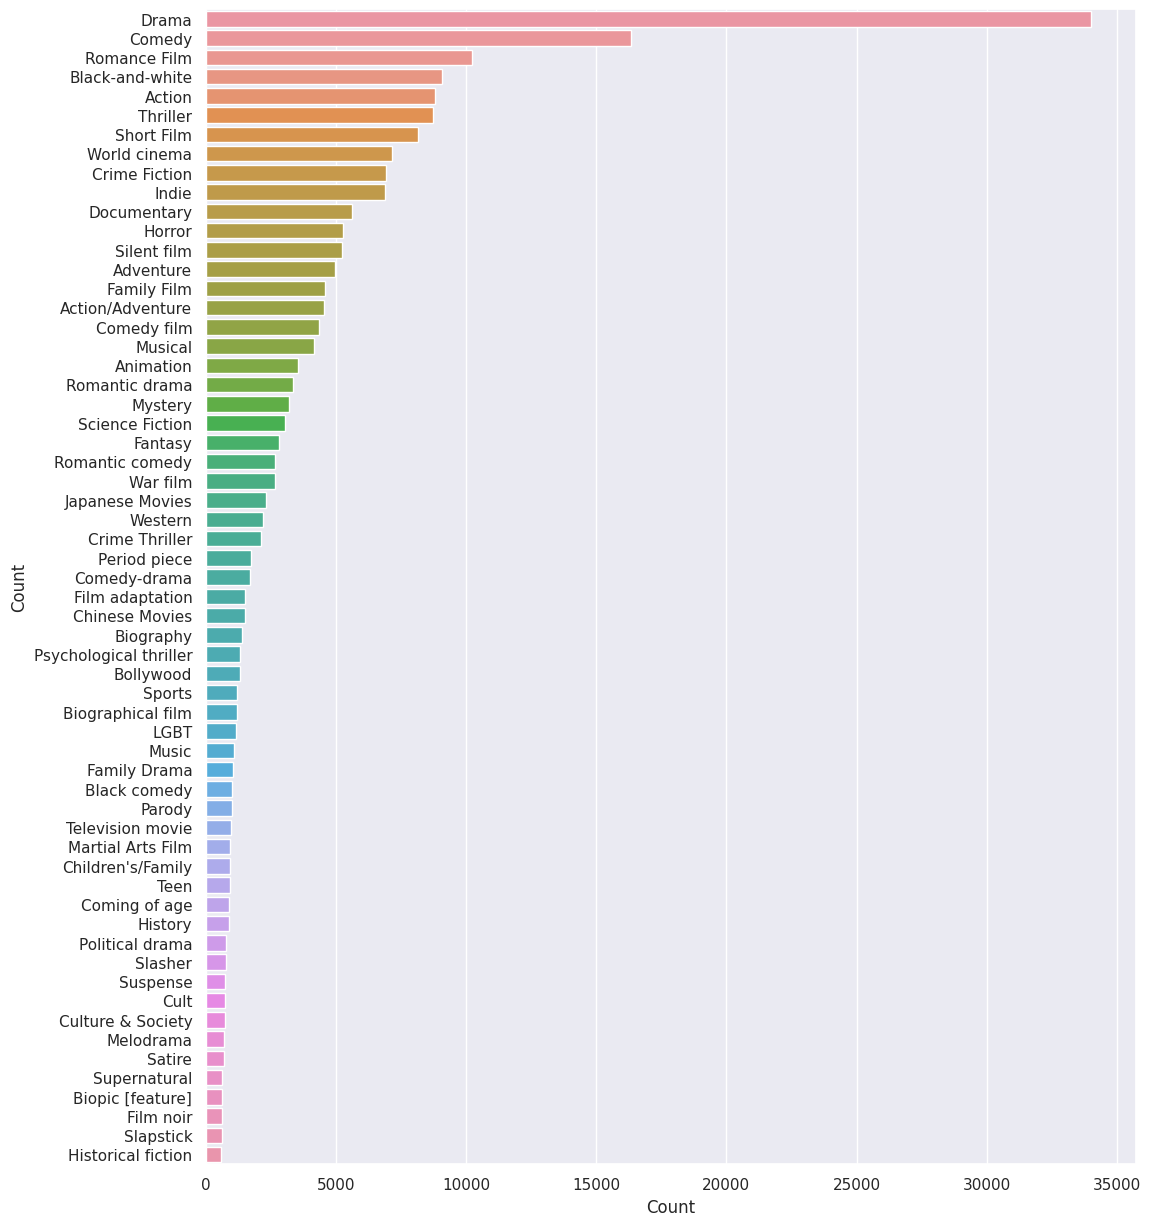

In [52]:
plot = todos_generos.nlargest(columns='Count',n=60)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=plot, x= 'Count', y='Genero')
ax.set(ylabel = 'Count')
plt.show()

## 3.1.2 WordCloud Genres Analysis

In [53]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [54]:
df_aux = df4.copy()

In [55]:
# Transform genres from list to string so we can add them into a wordcloud
df_aux['genero_filme'] = df_aux['genero_filme'].apply(lambda x: ','.join(x))

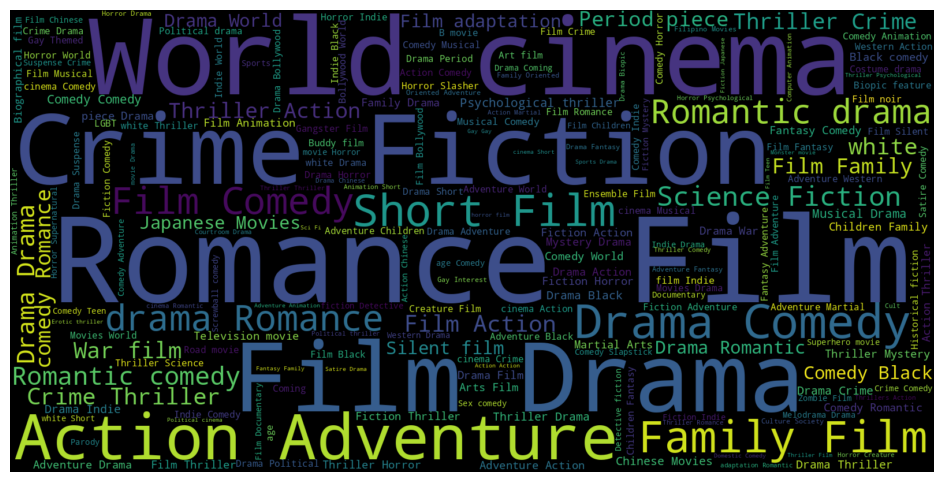

In [56]:
text = " ".join(i for i in df_aux['genero_filme'])
stopwords = set(STOPWORDS)
stopwords.update([',','.'])
wordcloud = WordCloud(stopwords=stopwords,background_color='black',width=1600,height=800).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


## 3.1.3 Number of Genders per Sinopse

In [57]:
df_aux['number_generos'] = df_aux['genero_filme'].apply(lambda x: len(x.split(',')))

In [58]:
df_aux.head()

,id_filme,nome_filme,genero_filme,sinopse_filme,number_generos
0,975900,Ghosts of Mars,"Thriller,Science Fiction,Horror,Adventure,Supe...","Set in the second half of the 22nd century, th...",7
3,9363483,White Of The Eye,"Thriller,Erotic thriller,Psychological thriller",A series of murders of rich young women throug...,3
4,261236,A Woman in Flames,Drama,"Eva, an upper class housewife, becomes frustra...",1
6,18998739,The Sorcerer's Apprentice,"Family Film,Fantasy,Adventure,World cinema","Every hundred years, the evil Morgana returns...",4
12,6631279,Little city,"Romantic comedy,Ensemble Film,Comedy-drama,Dra...","Adam, a San Francisco-based artist who works a...",7


In [59]:
print('Max number of genres per synopsis: {}'.format(max(df_aux['number_generos'])))
print('Min number of genres per synopsis: {}'.format(min(df_aux['number_generos'])))
print('Average number of genres per synopsis: {:.2f}'.format(sum(df_aux['number_generos']) / len(df_aux['number_generos'])))


Max number of genres per synopsis: 17
Min number of genres per synopsis: 1
Average number of genres per synopsis: 3.61


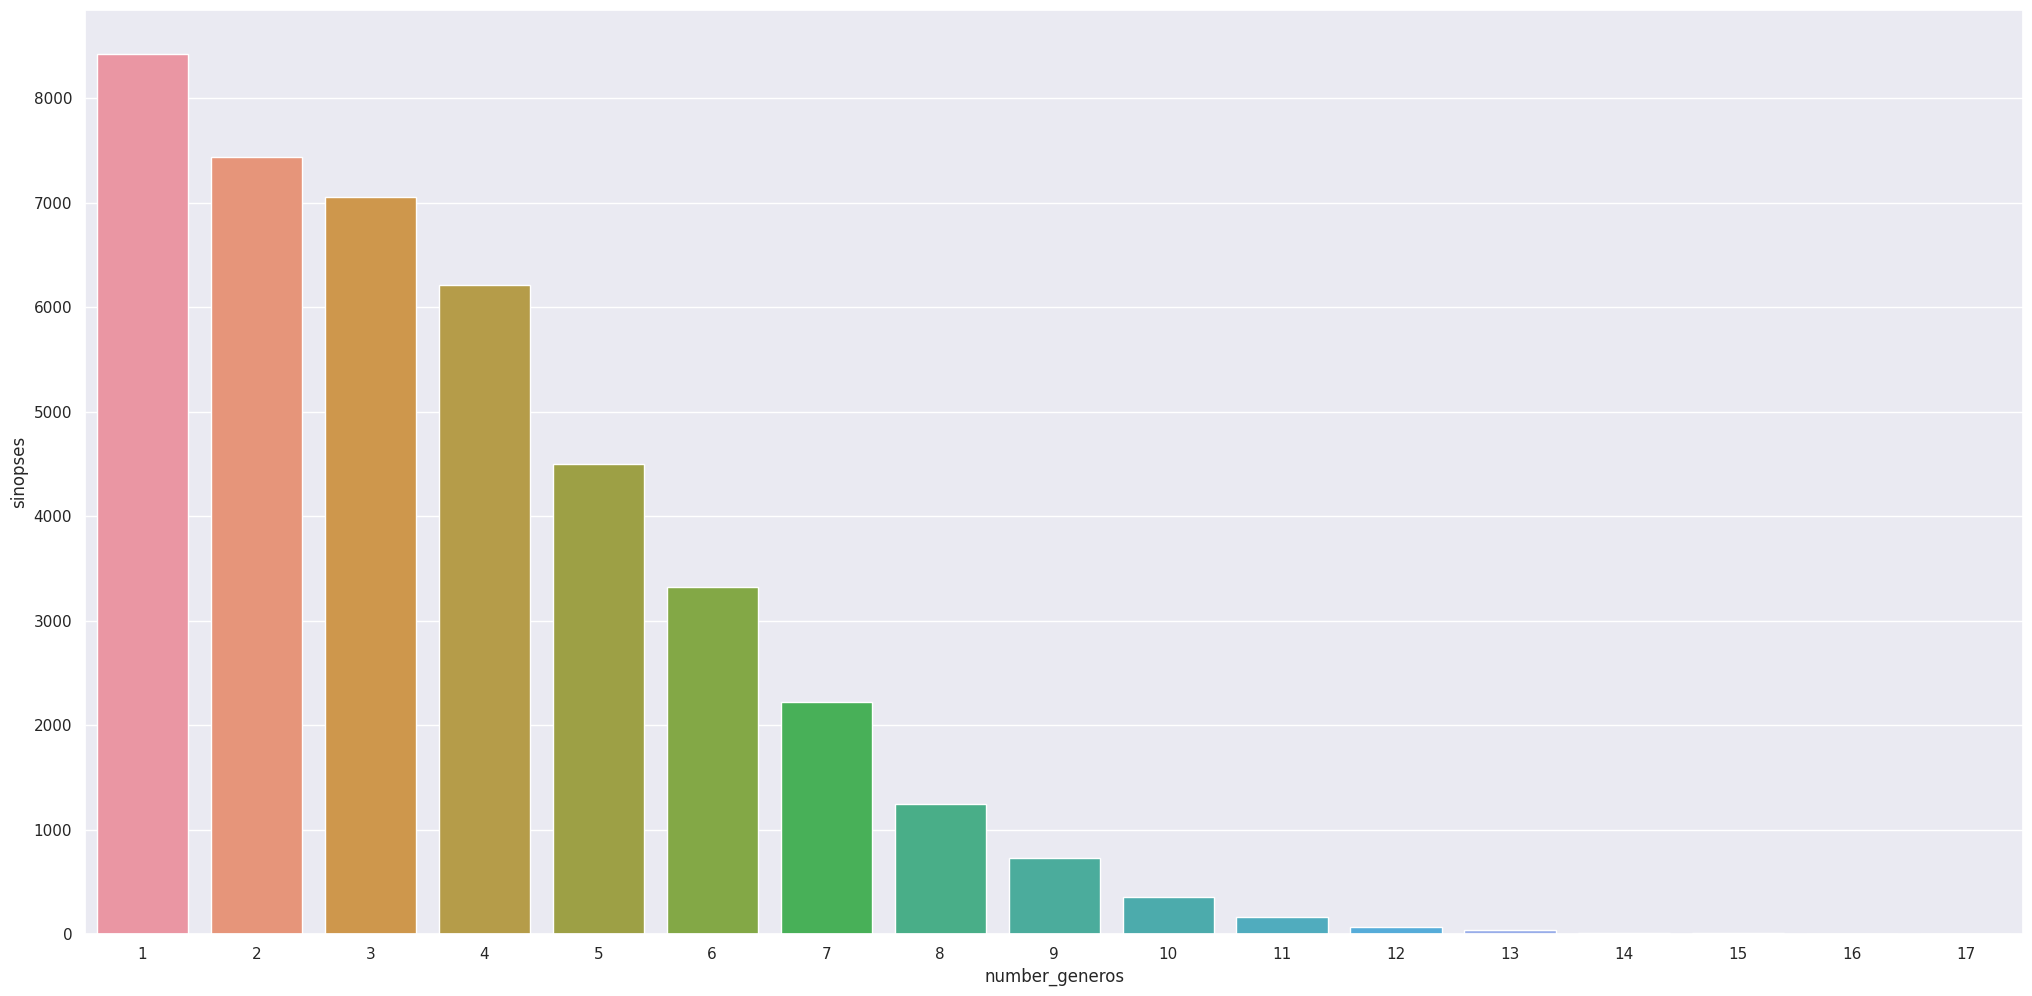

In [60]:
df_aux_2 = df_aux[['id_filme','number_generos']].groupby('number_generos').count().reset_index().rename(columns={'id_filme':'sinopses'})
df_aux_2 = df_aux_2.sort_values('sinopses',ascending=False)
sns.barplot(x='number_generos',y='sinopses',data=df_aux_2);

# 4.0 Data Preparation - PreProcessing and Cleaning

In [61]:
df5 = df4.copy()

In [62]:
df5.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


Preprocessing is one of the most important steps, and some techniques that can be used include:
* Removal of tokens and stopwords
* Selection of more important features
* Dimensionality Reduction
* Zipf's Law
* Applying stemming and N-Grams

We won't perform preprocessing in this first cycle precisely to see the difference in our model's performance in the next cycle.

# 5.0 Feature Creation

We will be focusing on the TF-IDF technique in this project to convert our train and test dataset into numerical vectors.

* The TF-IDF technique is a widely used text mining approach that aims to measure the relevance of a term in a document or corpus.
* It stands for Term Frequency-Inverse Document Frequency and consists of two parts: the term frequency (TF), which measures how frequently a term appears in a document, and the inverse document frequency (IDF), which measures how important a term is across the entire corpus.
* The TF-IDF score is the product of these two measures, where a high score indicates that a term is both frequent in a document and rare across the corpus, making it more relevant to the document

In [63]:
df5 = df5[['sinopse_filme','genero_filme']].copy()

In [64]:
df5.head()

,sinopse_filme,genero_filme
0,"Set in the second half of the 22nd century, th...","[Thriller, Science Fiction, Horror, Adventure,..."
3,A series of murders of rich young women throug...,"[Thriller, Erotic thriller, Psychological thri..."
4,"Eva, an upper class housewife, becomes frustra...",[Drama]
6,"Every hundred years, the evil Morgana returns...","[Family Film, Fantasy, Adventure, World cinema]"
12,"Adam, a San Francisco-based artist who works a...","[Romantic comedy, Ensemble Film, Comedy-drama,..."


In [65]:
# Creating TFIDFVectorizer only with the params max_features and stop_words 
tfidf = TfidfVectorizer(analyzer='word',max_features=10000,stop_words='english')
X = tfidf.fit_transform(df5['sinopse_filme'])

In [66]:
X

<41793x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3987040 stored elements in Compressed Sparse Row format>

In [67]:
y.shape

(41793, 363)

## 5.1 Split Train and Validation Dataset

In [68]:
x_train, x_validation, y_train, y_validation = train_test_split(X,y,test_size=0.2,random_state=42)

# 6.0 Model Testing

In [70]:
# Sotchastic gradient descente learning
sgd = SGDClassifier()

# LogisticRegression() -> check solvers 
lr = LogisticRegression(solver='lbfgs')

# Linear SVC
svc = LinearSVC()


**Define some initial metrics**

In [75]:
from sklearn.metrics import f1_score

In [76]:
def jaccard_score(y_true,y_pred):
    score = np.minimum(y_true,y_pred).sum(axis=1)/np.maximum(y_true,y_pred).sum(axis=1)
    return score.mean()*100

def print_score(y_pred,clf):
    print('CLF:',clf.__class__.__name__)
    print('Jaccard Score:{}'.format(jaccard_score(y_validation,y_pred)))
    

In [81]:
for classifier in [sgd,lr,svc]:
    clf = OneVsRestClassifier(classifier,n_jobs=-1)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_validation)
    print_score(y_pred,classifier)
    print(f1_score(y_validation,y_pred,average='weighted',zero_division=1))

/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


CLF: SGDClassifier
Jaccard Score:18.985173683702218
0.18618354399844536


/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


CLF: LogisticRegression
Jaccard Score:22.635421529727072
0.25399340224186034


/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


CLF: LinearSVC
Jaccard Score:27.934461907275644
0.3455711926712717


So for our initial model, the highest F1_SCORE Reached for our models is the one using OneVsRestClassifier using SVC as an estimator. In the next cycle we will talk a little bit more about those algorithms and define some other metrics to reach our final goal

# 7.0 Hyper-parameter Fine Tuning

# 8.0 Final Model

# 9.0 Predict Movie Genres

# 10.0 Model to Production

# 11.0 Next Cycle

In our first cycle, we conducted some brief analyses and determined which approach we will use to solve our problem. In the next cycle, we will delve a little deeper into some sections that were left aside and perform additional testing and modularization of some parts of the code.